In [1]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

True


# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [3]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '37242ba43',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython',
 'ipython_version': '8.12.0',
 'os_name': 'posix',
 'platform': 'Linux-5.15.0-1064-azure-x86_64-with-glibc2.10',
 'sys_executable': '/anaconda/envs/azureml_py38/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'}


In [4]:
# %pip install -r "C:\Users\jesus\Desktop\Projecte\XNAPproject-grup07\our_code\frozen-requirements.txt" 

# %pip install -r '/home/xnmaster/Project/XNAPproject-grup07/our_code/frozen-requirements.txt'

In [5]:
# %pip install tensorflow[and-cuda]

In [6]:
# %pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

In [7]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3265073924121607648
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15247015936
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3523581805883102424
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [8]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [9]:
# %pip install Pillow --upgrade

In [10]:
DATA_DIR = r"C:\Users\jesus\Desktop\Projecte"
TRAIN_1_DIR = r"C:\Users\jesus\Desktop\Projecte\train_10_artists\train_10_artists"
#TRAIN_2_DIR = r"C:\Users\jesus\Desktop\Projecte\imatges\train_9\train_9"


TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = r"C:\Users\jesus\Desktop\Projecte\test"

In [11]:
# globals

DATA_DIR = '/home/xnmaster/project'
TRAIN_1_DIR = '/home/xnmaster/project/train_30_artists'

TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = "/home/xnmaster/project/test"

Execute in local and virtual
(no cal cada vegada, només una vegada pq elimina les fotos que no són vàlides)

In [12]:
from PIL import Image
import os

# Function to check if a file is an image
def is_image(file_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return any(file_path.lower().endswith(ext) for ext in image_extensions)

# Function to check if an image file is valid
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        print(f"Invalid image: {file_path} - {e}")
        # Remove the file if it's invalid
        os.remove(file_path)
        print(f"Removed file: {file_path}")
        return False

# Validate images in a directory
def validate_images(directory):
    print(f"Validating images in directory: {directory}")
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and is_image(file_path):
            if is_valid_image(file_path):
                print(f"Valid image: {file_path}")

# Validate training and testing directories
def validate_directories(*directories):
    for directory in directories:
        if not os.path.exists(directory):
            raise ValueError(f"Directory does not exist: {directory}")
        if not os.path.isdir(directory):
            raise ValueError(f"Not a directory: {directory}")

# Validate training and testing directories
validate_directories(DATA_DIR, TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_directories(train_dir)

# Validate images in training and testing directories
validate_images(DATA_DIR)
validate_images(TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_images(train_dir)


Validating images in directory: /home/xnmaster/project
Validating images in directory: /home/xnmaster/project/test
Validating images in directory: /home/xnmaster/project/train_30_artists
Valid image: /home/xnmaster/project/train_30_artists/50431.jpg
Valid image: /home/xnmaster/project/train_30_artists/100527.jpg
Valid image: /home/xnmaster/project/train_30_artists/63836.jpg
Valid image: /home/xnmaster/project/train_30_artists/63075.jpg
Valid image: /home/xnmaster/project/train_30_artists/14300.jpg
Valid image: /home/xnmaster/project/train_30_artists/51014.jpg
Valid image: /home/xnmaster/project/train_30_artists/52398.jpg
Valid image: /home/xnmaster/project/train_30_artists/37193.jpg
Valid image: /home/xnmaster/project/train_30_artists/16674.jpg
Valid image: /home/xnmaster/project/train_30_artists/23945.jpg
Valid image: /home/xnmaster/project/train_30_artists/21221.jpg
Valid image: /home/xnmaster/project/train_30_artists/18473.jpg
Valid image: /home/xnmaster/project/train_30_artists/363

In [13]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 8180
Number of files in the folder TEST_DIR: 0


After augmentation

In [14]:
df = pd.read_csv("../all_data_info.csv") # r'\train_info\train_info.csv'
print("df.shape", df.shape)

df.shape (103250, 12)


In [15]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [16]:
# quick fix for corrupted files
list_of_corrupted = ['3917.jpg','18649.jpg','20153.jpg','41945.jpg',
'79499.jpg','91033.jpg','92899.jpg','95347.jpg',
'100532.jpg','101947.jpg']
# display the corrupted rows of dataset for context
corrupt_df = df[df["new_filename"].isin(list_of_corrupted) == True]
print(corrupt_df.head(len(list_of_corrupted)))

# completely get rid of them
df = df[df["new_filename"].isin(list_of_corrupted) == False]

# try to see if they are still there
print(df[df["new_filename"].isin(list_of_corrupted) == True])

print("df.shape", df.shape)

                             artist    date              genre  pixelsx  \
185                  Giorgio Vasari    1534           portrait   3512.0   
731                       Juan Gris    1918          cityscape   2844.0   
994                       Juan Gris    1917         still life   3918.0   
1084   John Roddam Spencer Stanhope    1860     genre painting   4249.0   
1105                 Henri Rousseau    1908          cityscape   3403.0   
9984   John Roddam Spencer Stanhope     NaN  symbolic painting   1309.0   
19876              Georgia O'Keeffe  1915.0           abstract   1400.0   
28748                    Franz Marc    1913    animal painting    951.0   
46256           Esaias van de Velde    1622          landscape    942.0   
98236                 George Inness     NaN  literary painting    376.0   

       pixelsy  size_bytes     source                         style  \
185     4850.0  10360549.0    wikiart  Mannerism (Late Renaissance)   
731     3882.0   5393504.0    wi

Keep the works of artists who have a representation above 50%

In [17]:
# Step 1: Count occurrences of each artist
artist_counts = df['artist'].value_counts()

Artists

In [18]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

# artists = {} # holds artist hash & the count
# for a in filtered_df['artist']:
#     if (a not in artists):
#         artists[a] = 1
#     else:
#         artists[a] += 1

# training_set_artists = []
# for a,count in artists.items():
#     if(int(count) >= 200): # it takes no more than 200 artists
#         training_set_artists.append(a)

# print("number of artists",len(training_set_artists))

# print("\nlist of artists...\n", training_set_artists)


test_df.shape (23814, 2)
train_df.shape (103240, 2)


In [19]:
artists = {'Ivan Aivazovsky': 500,
 'John Singer Sargent': 500,
 'Pierre-Auguste Renoir': 500,
 'Marc Chagall': 500,
 'Pablo Picasso': 500,
 'Zdislav Beksinski': 500,
 'Ivan Shishkin': 500,
 'Gustave Dore': 500,
 'Ilya Repin': 500,
 'Giovanni Battista Piranesi': 500}

In [20]:
training_set_artists = ['Ivan Aivazovsky',
 'John Singer Sargent',
 'Pierre-Auguste Renoir',
 'Marc Chagall',
 'Pablo Picasso',
 'Zdislav Beksinski',
 'Ivan Shishkin',
 'Gustave Dore',
 'Ilya Repin',
 'Giovanni Battista Piranesi']

In [21]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
82,Ivan Aivazovsky,81750.jpg


In [22]:
t1_df = t_df[t_df['new_filename'].str.startswith('1')]

t2_df = t_df[t_df['new_filename'].str.startswith('2')]

t3_df = t_df[t_df['new_filename'].str.startswith('3')]

t4_df = t_df[t_df['new_filename'].str.startswith('4')]

t5_df = t_df[t_df['new_filename'].str.startswith('5')]

t6_df = t_df[t_df['new_filename'].str.startswith('6')]

t7_df = t_df[t_df['new_filename'].str.startswith('7')]

t8_df = t_df[t_df['new_filename'].str.startswith('8')]

t9_df = t_df[t_df['new_filename'].str.startswith('9')]

all_train_dfs = [t1_df, t2_df, t3_df,
                t4_df, t5_df, t6_df,
                t7_df, t8_df, t9_df]

t9_df.head(5)

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
591,Giovanni Battista Piranesi,96147.jpg
634,Giovanni Battista Piranesi,94943.jpg
681,Giovanni Battista Piranesi,97939.jpg
748,Giovanni Battista Piranesi,98150.jpg


In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# specify the model that classifies 38 artists 🎨 🖌

## wandb
Execute following lines if we use wandb

In [24]:
# %pip install wandb -qU

In [25]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

#wandb.login(relogin=True)

# 0927244f833ccea1b247099feaaaf54084a5c30c
# ari e6e64b9f07ca2cefafe987916faba0e4ad03ae09

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ERROR API key must be 40 characters long, yours was 16
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ERROR API key must be 40 characters long, yours was 16
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an

True

## without wandb

In [26]:
len(training_set_artists)

10

In [27]:
# augmentation_layers = [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
# ]


# def data_augmentation(x):
#     for layer in augmentation_layers:
#         x = layer(x)
#     return x


# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [28]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

model_adam.layers[0].trainable = False

In [29]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2

model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dropout(0.4))  # Afegim una capa de Dropout amb una taxa de 0.5 per reduir l'overfitting
model_adam.add(Dense(
  num_classes,
  activation='softmax',
  kernel_regularizer=l2(0.01)  # Afegim regularització L2 amb un factor de regularització de 0.01
))

model_adam.layers[0].trainable = False


In [30]:
model_sgd = Sequential()

model_sgd.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_sgd.add(Dense(
  num_classes,
  activation='softmax'
))

model_sgd.layers[0].trainable = False

In [31]:
model_RMS = Sequential()
model_RMS.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_RMS.add(Dense(
  num_classes,
  activation='softmax'
))

model_RMS.layers[0].trainable = False

# Compile Model

## Adam

In [32]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

**Observation**
para un problema de clasificación binaria, a menudo se utiliza la 'entropía cruzada binaria', mientras que la 'entropía cruzada categórica' se utiliza para la clasificación de clases múltiples.
https://www.sourcetrail.com/es/pit%C3%B3n/keras/modelo-compilar-keras/

## SGD

In [33]:
model_sgd.compile(
  optimizer='sgd', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

## RMSprop

In [34]:
model_RMS.compile(optimizer ='RMSprop', 
              loss ='categorical_crossentropy', 
              metrics =['accuracy'])

# Setup the image data generator for each training directory 

In [35]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)

Number of files in the folder TRAIN_1_DIR: 8180
Number of files in the folder TEST_DIR: 0


In [36]:
def batch_size(num_fitxers, max_batch_size=64):
    for size in range(max_batch_size, 0, -1):
        if num_fitxers % size == 0:
            return size
    return 1 

BATCH_SIZE = batch_size(num_files_in_train)
TEST_BATCH_SIZE = batch_size(num_files_in_test)

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"TEST_BATCH_SIZE: {TEST_BATCH_SIZE}")


BATCH_SIZE: 20
TEST_BATCH_SIZE: 64


In [37]:
# model globals
IMAGE_SIZE = 224
VAL_SPLIT = 0.25

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

def setup_generators_with_augmentation(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-"*20)
    if not preprocess_input:
        raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # Data augmentation for training set
    train_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation and test sets
    valid_test_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split
    )

    print(len(train_dataframe), "images in", train_dir, "and validation_split =", val_split)
    
    print("\ntraining set ImageDataGenerator with augmentation")
    train_gen = train_data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        subset="training",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nvalidation set ImageDataGenerator")
    valid_gen = valid_test_data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        subset="validation",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size, img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\ntest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(),
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False,
        class_mode=None,
        target_size=(img_size, img_size)
    )

    return train_gen, valid_gen, test_gen

print("defined setup_generators_with_augmentation()")


defined setup_generators_with_augmentation()


In [39]:
# delete some unused dataframes to free some RAM for training
del df
# del t_df
del t1_df
del t2_df
del t3_df
del t4_df
del t5_df
del t6_df
del t7_df
del t8_df
del t9_df
gc.collect()

24181

In [40]:
t_df

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
82,Ivan Aivazovsky,81750.jpg
...,...,...
85626,Zdislav Beksinski,98069.jpg
85633,Zdislav Beksinski,101416.jpg
85720,Zdislav Beksinski,62958.jpg
85789,Zdislav Beksinski,78737.jpg


In [41]:
len(all_train_dfs)

9

In [42]:
all_train_dfs[0]

,artist,new_filename
602,Giovanni Battista Piranesi,11889.jpg
668,Giovanni Battista Piranesi,19571.jpg
697,Giovanni Battista Piranesi,14108.jpg
773,Giovanni Battista Piranesi,1155.jpg
784,Giovanni Battista Piranesi,18290.jpg
...,...,...
84070,Zdislav Beksinski,15108.jpg
84115,Zdislav Beksinski,101998.jpg
85235,Zdislav Beksinski,18742.jpg
85237,Zdislav Beksinski,10293.jpg


In [43]:
train_gens = [None] 
valid_gens = [None]
test_gen  = None  # only 1 test_gen

i=0
for i in range(0,1):
    train_gens[i], valid_gens[i], test_gen = setup_generators_with_augmentation(
        train_dataframe=t_df, train_dir=TRAIN_DIRS[0],
        val_split=VAL_SPLIT, img_size=IMAGE_SIZE, batch_size=BATCH_SIZE, my_seed=MY_SEED,
        list_of_classes=training_set_artists, test_dataframe=test_df,
        test_dir=TEST_DIR, test_batch_size=TEST_BATCH_SIZE
    )

--------------------
5000 images in /home/xnmaster/project/train_30_artists and validation_split = 0.25

training set ImageDataGenerator with augmentation
Found 2061 validated image filenames belonging to 10 classes.

validation set ImageDataGenerator
Found 686 validated image filenames belonging to 10 classes.

test set ImageDataGenerator


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2253 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2253 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames.


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 23814 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [44]:
MAX_EPOCHS =  20 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [45]:
MAX_EPOCHS

20

In [46]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## wandb

In [47]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_augmentation_dropout"
    # track hyperparameters and run metadata with wandb.config
    # config={
    #     "layer_1": 512,
    #     "activation_1": "softmax", # relu
    #     "dropout": random.uniform(0.01, 0.80),
    #     "layer_2": 10,
    #     # "activation_2": "softmax",
    #     "optimizer": "adam",
    #     "loss": "sparse_categorical_crossentropy",
    #     "metric": "accuracy",
    #     "epoch": 8,
    #     "batch_size": 256,
    # },
)

# [optional] use wandb.config as your config
# config = run.config


wandb: Currently logged in as: 1608667 (xarxes_projecte). Use `wandb login --relogin` to force relogin


In [ ]:
histories_adam = model_adam.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
38/38 [==============================] - 88s 2s/step - loss: 1.9147 - accuracy: 0.4544 - val_loss: 5.9076 - val_accuracy: 0.3600
Epoch 2/20
38/38 [==============================] - 80s 2s/step - loss: 1.0991 - accuracy: 0.7097 - val_loss: 5.5892 - val_accuracy: 0.3785
Epoch 3/20
38/38 [==============================] - 81s 2s/step - loss: 0.8906 - accuracy: 0.7579 - val_loss: 4.9690 - val_accuracy: 0.4092
Epoch 4/20
38/38 [==============================] - 80s 2s/step - loss: 0.8303 - accuracy: 0.7779 - val_loss: 4.9150 - val_accuracy: 0.4092
Epoch 5/20
38/38 [==============================] - 80s 2s/step - loss: 0.7241 - accuracy: 0.8046 - val_loss: 4.8247 - val_accuracy: 0.4046
Epoch 6/20
38/38 [==============================] - 80s 2s/step - loss: 0.6806 - accuracy: 0.8287 - val_loss: 4.7087 - val_accuracy: 0.4246
Epoch 7/20
38/38 [==============================] - 80s 2s/step - loss: 0.6192 - accuracy: 0.8436 - val_loss: 4.7889 - val_accuracy: 0.4200
Epoch 8/20
38/38 [==

In [ ]:
run.finish()

batch/accuracy,▁▂▅▆▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇█▇█▇█▇█▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▅▅▅▆▆▆▆▆▆▇▇▇▅▅█▇█▆
epoch/val_loss,█▆▃▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▁
batch/accuracy,0.90571


In [ ]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "sgd_augmentation"
)

In [ ]:
histories_sgd = model_sgd.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/30
8/8 [==============================] - 23s 3s/step - loss: 2.3955 - accuracy: 0.2132 - val_loss: 3.5546 - val_accuracy: 0.1527
Epoch 2/30
8/8 [==============================] - 17s 2s/step - loss: 1.5401 - accuracy: 0.5051 - val_loss: 3.6294 - val_accuracy: 0.2595
Epoch 3/30
8/8 [==============================] - 16s 2s/step - loss: 1.2671 - accuracy: 0.5584 - val_loss: 3.8308 - val_accuracy: 0.2748
Epoch 4/30
8/8 [==============================] - 17s 2s/step - loss: 1.0855 - accuracy: 0.6320 - val_loss: 4.0578 - val_accuracy: 0.2748
Epoch 5/30
8/8 [==============================] - 16s 2s/step - loss: 0.9121 - accuracy: 0.6904 - val_loss: 4.0505 - val_accuracy: 0.2977
Epoch 6/30
8/8 [==============================] - 16s 2s/step - loss: 0.8005 - accuracy: 0.7614 - val_loss: 3.9908 - val_accuracy: 0.3435
Epoch 7/30
8/8 [==============================] - 16s 2s/step - loss: 0.7397 - accuracy: 0.7716 - val_loss: 4.1745 - val_accuracy: 0.2977
Epoch 8/30
8/8 [==================

In [ ]:
run.finish()

batch/accuracy,▁▃▄▆▆▇▇▆▆▆▇▇▇▇▇▆█▇▇▇▇▇▇█▇█▇█▇▇
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▁▂▁▁▁
epoch/accuracy,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▅▅▇▅▅▆▇▆▆▇█▆▇██▇▇██▇██▇▇███
epoch/val_loss,▁▁▂▄▄▃▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
batch/accuracy,0.90385


In [ ]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "RMS_augmentation"
)

In [ ]:
histories_RMS = model_RMS.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/30
8/8 [==============================] - 23s 3s/step - loss: 2.2476 - accuracy: 0.3020 - val_loss: 3.8700 - val_accuracy: 0.3053
Epoch 2/30
8/8 [==============================] - 16s 2s/step - loss: 1.2580 - accuracy: 0.5787 - val_loss: 4.0948 - val_accuracy: 0.3435
Epoch 3/30
8/8 [==============================] - 16s 2s/step - loss: 0.9856 - accuracy: 0.6777 - val_loss: 4.0593 - val_accuracy: 0.3893
Epoch 4/30
8/8 [==============================] - 16s 2s/step - loss: 0.8103 - accuracy: 0.7437 - val_loss: 4.6906 - val_accuracy: 0.3511
Epoch 5/30
8/8 [==============================] - 16s 2s/step - loss: 0.7298 - accuracy: 0.7843 - val_loss: 4.8050 - val_accuracy: 0.4198
Epoch 6/30
8/8 [==============================] - 16s 2s/step - loss: 0.6275 - accuracy: 0.7970 - val_loss: 5.0559 - val_accuracy: 0.3893
Epoch 7/30
8/8 [==============================] - 16s 2s/step - loss: 0.5225 - accuracy: 0.8452 - val_loss: 5.1536 - val_accuracy: 0.4198
Epoch 8/30
8/8 [==================

In [ ]:
run.finish()

batch/accuracy,▁▄▆▆▇▇▇▆▇▇█▇▇████▇████████████
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇██▇████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▆▄█▆█▇▆▆▆▆▇▄▅▇▆▆▅▇█▇▇▄▆▇▆▆▆▆
epoch/val_loss,▁▁▁▃▃▃▃▄▄▄▅▅▆▆▆▆▆▇▆▆▇▆▇█▇▇▇███
batch/accuracy,0.98077


## manual

In [ ]:
histories_sgd = []

e=0
while ( e < MAX_EPOCHS):
    print('epoca',e)
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_sgd.append(
            model_sgd.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

epoca 0
STEP_SIZE_TRAIN 103
STEP_SIZE_VALID 34


2024-05-24 10:05:44.358123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2024-05-24 10:05:44.358212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Possibly insufficient driver version: 470.239.6


UnimplementedError: Graph execution error:

Detected at node 'sequential_6/resnet50/conv1_conv/Conv2D' defined at (most recent call last):
    File "/anaconda/envs/azureml_py38/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/anaconda/envs/azureml_py38/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/anaconda/envs/azureml_py38/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/anaconda/envs/azureml_py38/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/anaconda/envs/azureml_py38/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_38601/3916214603.py", line 14, in <module>
      model_sgd.fit(train_gens[i],
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_6/resnet50/conv1_conv/Conv2D'
DNN library is not found.
	 [[{{node sequential_6/resnet50/conv1_conv/Conv2D}}]] [Op:__inference_train_function_45087]

In [ ]:
histories_adam2 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam2.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 22s 3s/step - loss: 2.4313 - accuracy: 0.1667 - val_loss: 4.6034 - val_accuracy: 0.2019
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 14s 2s/step - loss: 1.7322 - accuracy: 0.4353 - val_loss: 4.2694 - val_accuracy: 0.3173
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 15s 4s/step - loss: 1.3692 - accuracy: 0.5433 - val_loss: 6.5971 - val_accuracy: 0.1731
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 1.0750 - accuracy: 0.6335 - val_loss: 6.2746 - val_accuracy: 0.2115
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 1.0708 - accuracy: 0.6653 - val_loss: 6.8493 - val_accuracy: 0.2885
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 15s 3s/step - loss: 0.9036 - accuracy: 0.6654 - val_loss: 6.4040 - val_accuracy: 0.3365
STEP_SIZE_TRAIN 7
STEP

In [ ]:
histories_RMS = []

e=0
while ( e < MAX_EPOCHS):
    print('epoca',e)
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_RMS.append(
            model_RMS.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

0
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2


7/7 [==============================] - 22s 3s/step - loss: 2.3141 - accuracy: 0.2895 - val_loss: 5.2543 - val_accuracy: 0.1058
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 14s 3s/step - loss: 1.4080 - accuracy: 0.5468 - val_loss: 4.7613 - val_accuracy: 0.2308
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 1.3945 - accuracy: 0.5433 - val_loss: 5.9008 - val_accuracy: 0.1731
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 13s 3s/step - loss: 1.0456 - accuracy: 0.6574 - val_loss: 5.3847 - val_accuracy: 0.1731
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 15s 3s/step - loss: 1.0703 - accuracy: 0.6653 - val_loss: 5.3897 - val_accuracy: 0.2885
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 15s 2s/step - loss: 0.9264 - accuracy: 0.6992 - val_loss: 5.8311 - val_accuracy: 0.2404
6
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [===============

KeyboardInterrupt: 

# Evaluate the model 🧐 🤔

In [ ]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

TypeError: 'History' object is not iterable

In [ ]:
accuracies_sgd = []
val_accuracies_sgd = []
losses_sgd = []
val_losses_sgd = []
for hist in histories_sgd:
    if hist:
        accuracies_sgd += hist.history['accuracy']
        val_accuracies_sgd += hist.history['val_accuracy']
        losses_sgd += hist.history['loss']
        val_losses_sgd += hist.history['val_loss']

In [ ]:
accuracies_RMS = []
val_accuracies_RMS = []
losses_RMS = []
val_losses_RMS = []
for hist in histories_RMS:
    if hist:
        accuracies_RMS += hist.history['accuracy']
        val_accuracies_RMS += hist.history['val_accuracy']
        losses_RMS += hist.history['loss']
        val_losses_RMS += hist.history['val_loss']

## Plots
### Accuracies

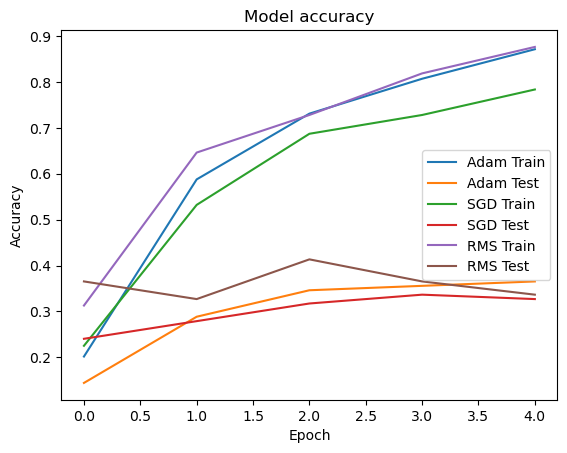

In [ ]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.plot(accuracies_sgd, label = "SGD Train")
plt.plot(val_accuracies_sgd, label = "SGD Test")

plt.plot(accuracies_RMS, label = "RMS Train")
plt.plot(val_accuracies_RMS, label = "RMS Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Loss values

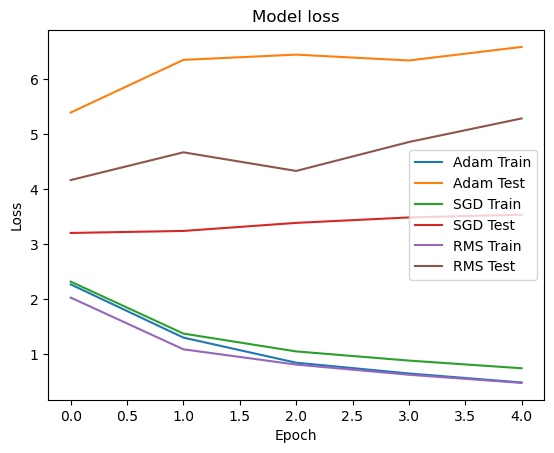

In [ ]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.plot(losses_sgd, label = "SGD Train")
plt.plot(val_losses_sgd, label = "SGD Test")

plt.plot(losses_RMS, label = "RMS Train")
plt.plot(val_losses_RMS, label = "RMS Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

# Predict the output 🔮 🎩

In [ ]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

281

In [ ]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

In [ ]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

## Adam

In [ ]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

281/281 [==============================] - 229s 767ms/step


In [ ]:
print(len(pred_adam),"\n",pred_adam)

10113 
 [[8.04727257e-04 4.04767739e-03 3.89879569e-04 ... 5.35861496e-03
  2.05516844e-05 8.24720628e-05]
 [1.09930761e-05 7.13876216e-04 1.25340803e-03 ... 9.94388130e-04
  3.79198559e-06 2.49061541e-05]
 [1.51381202e-04 8.74841469e-04 3.75820309e-05 ... 6.74502342e-04
  4.13899579e-06 4.49073195e-05]
 ...
 [1.39237553e-01 1.04452565e-01 7.60575582e-04 ... 7.46746222e-03
  5.34233376e-02 2.08907411e-03]
 [1.77956317e-04 6.74847901e-01 6.08954020e-02 ... 8.75055033e-04
  1.24265872e-01 2.19740643e-04]
 [4.03708927e-02 1.24865668e-02 5.25613362e-03 ... 1.17507484e-02
  2.11067483e-01 1.39211980e-03]]


In [ ]:
predicted_class_indices_adam=np.argmax(pred_adam,axis=1)

In [ ]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

10113 
 [4 4 4 ... 5 1 5]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 10113 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [ ]:
results_adam.head()

,Filename,Predictions,Real Values
0,32145.jpg,Pablo Picasso,kiri nichol
1,20304.jpg,Pablo Picasso,kiri nichol
2,836.jpg,Pablo Picasso,kiri nichol
3,49823.jpg,Pablo Picasso,Hiroshige
4,84512.jpg,John Singer Sargent,Franz Richard Unterberger


In [ ]:
len(training_set_artists)

10

In [ ]:
print(training_set_artists)

['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [ ]:
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists


ZeroDivisionError: division by zero

## SGD

In [ ]:
test_gen.reset()
pred_sgd = model_sgd.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_sgd),"\n",pred_sgd)

  5/281 [..............................] - ETA: 33:23

KeyboardInterrupt: 

In [ ]:
predicted_class_indices_sgd = np.argmax(pred_sgd,axis=1)

In [ ]:
results_sgd = retrieve_results(predicted_class_indices_sgd, train_gens)
results_sgd.head()

7025 
 [4 3 2 ... 3 1 3]
it has values ranging from  0 ...to... 9
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,Ivan Shishkin,Jan Matejko


In [ ]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [ ]:
testing_new_images(results_sgd, training_set_artists)

test accuracy on new images for TRAINED artists
227 / 335 = 0.6776
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
227 / 7025 = 0.0323


## RMSprop

In [ ]:
test_gen.reset()
pred_RMS = model_RMS.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_RMS),"\n",pred_RMS)

281/281 [==============================] - 194s 655ms/step
7025 
 [[2.1443799e-02 2.7314452e-03 1.9525861e-03 ... 7.1664699e-06
  7.4858626e-04 1.2445415e-03]
 [1.7144992e-04 4.5708535e-04 4.1855793e-07 ... 1.9475513e-06
  8.5016536e-03 8.8260066e-07]
 [1.5640775e-03 3.2066507e-03 8.0450183e-01 ... 5.2702957e-04
  6.6229612e-02 1.8388973e-06]
 ...
 [6.5013796e-02 1.3065257e-03 2.0052115e-05 ... 5.2633203e-07
  1.7853242e-01 1.7775544e-07]
 [5.2264878e-03 6.4723516e-01 5.4563824e-02 ... 3.0369400e-03
  1.5838053e-02 4.9470534e-04]
 [5.6721634e-05 4.6246450e-02 6.1807758e-03 ... 6.9209425e-05
  7.8524435e-03 2.4185749e-05]]


In [ ]:
predicted_class_indices_RMS = np.argmax(pred_RMS,axis=1)

In [ ]:
results_RMS = retrieve_results(predicted_class_indices_RMS, train_gens)
results_RMS.head()

7025 
 [4 3 2 ... 3 1 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,John Singer Sargent,Jan Matejko


In [ ]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [ ]:
testing_new_images(results_RMS, training_set_artists)

test accuracy on new images for TRAINED artists
231 / 335 = 0.6896
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
231 / 7025 = 0.0329


# Ideas
- Having a the prediction dataset: Filename, Predictions, Real Values. We can construct a composition of the predictions.
- We can now predict artist and another caracteristic (like stryle).

## Mosaics

In [ ]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


### Predictions

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/compositions/predictions_13000_images/composition_{}.png'.format(predicted_artist))


### Real values

In [ ]:
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

In [ ]:

grouped_data

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
filtered_data = results_adam[results_adam['Real Values'].isin(training_set_artists)]
grouped_data = filtered_data.groupby('Real Values')# tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/XNAPproject-grup07/compostions/real_values_13000_images/composition_{}.png'.format(predicted_artist))


Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 99, in run
    sreq = self._sock_client.read_server_request()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 274, in read_server_request
    data = self._read_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 248, in _read_packet_bytes
    rec = self._extract_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 230, in _extract_packet_bytes
    assert magic == ord("W")
AssertionError
Bad pipe message: %s [b'\xd2\xe9\xa0\xf1I\xb7}r\xe0\x7f\xc0\x83\xc1\xa2A\xa6\xeb\x8e P\xa0f\xb6\xd3\x198\x0e\x8e\xcag\xf0', b'\x19a\x03u\xba\xbe\xfb\x